이번 프로젝트는 keypoint detection를 통해 사람 이미지에 원하는 이미지를 스티커처럼 붙여넣는 것을 목적으로 한다. 

In [1]:
# 라이브러리 실행

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

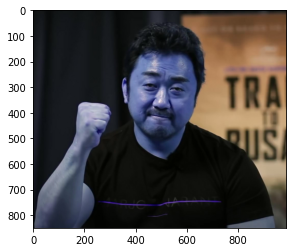

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr)
plt.show()

opencv는 이미지 채널을 BGR 순으로 사용하기 때문에 RGB로 바꾸어 색깔 보정처리를 해주어야 한다. 

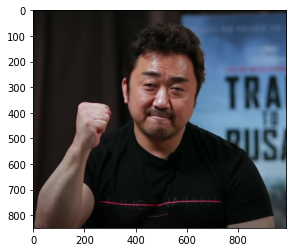

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)    # 이미지 색 보정처리
plt.imshow(img_rgb)
plt.show()

dlib의 face detector는 HOG와 SVM을 사용해 얼굴을 찾아낸다.

In [4]:
# detector 선언

detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(379, 231) (646, 498)]]


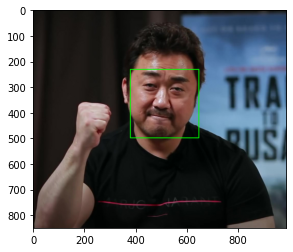

In [5]:
# 찾은 얼굴의 영역을 박스로 표시

print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [6]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


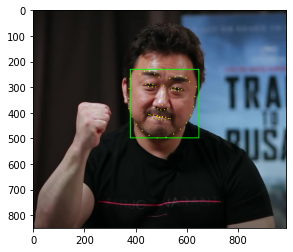

In [8]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(503, 370)
(x,y) : (503,236)
(w,h) : (268,268)


In [10]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(268, 268, 3)


In [11]:
refined_x = x - w // 2
refined_y = y - h - 50
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (369,-82)


In [12]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (369,0)


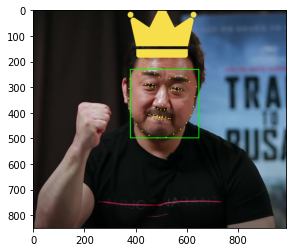

In [13]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

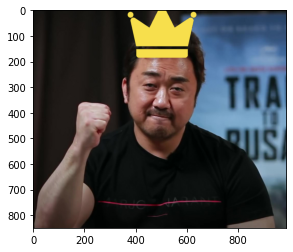

In [14]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()